In [1]:
import numpy as np

import torch 
import torch.optim as optim
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bands = np.load('./test/bands.npy')
masks = np.load('./test/masks.npy')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
B08 = bands[:, :, 6]
B04 = bands[:, :, 2]
NDVI =  np.nan_to_num((B08 - B04) / (B08 + B04))

data = np.concatenate([bands, NDVI[...,np.newaxis], masks[..., np.newaxis]], axis=2)
print(data.shape)

(16021, 151, 10)


<ipython-input-4-c4f9a1121d47>:3: RuntimeWarning: invalid value encountered in true_divide
  NDVI =  np.nan_to_num((B08 - B04) / (B08 + B04))


In [5]:
masks_ = torch.Tensor(masks).to(device)
masks_[masks_ == 1.] = 2.
masks_[masks_ == 0.] = 1.
masks_[masks_ == 2.] = 0.
masks_ = masks_.reshape([16021, 1, 151, 1])

masks_ = torch.cat([masks_ for _ in range(10)], dim=3)
masks_[:,:,:,8] = 0.
masks_[:,:,:,9] = 0.
masks_.shape

torch.Size([16021, 1, 151, 10])

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.coder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 10), stride=(1,1), padding=(1,0)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2,1),  stride=(2,1)),

        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 10), padding=(2,0)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, kernel_size=(7,1), stride=(2, 1)), 
            nn.ReLU()
        )
        
    def forward(self, x):
        out = self.coder(x)
        out = self.decoder(out)
        return out.view((16021, 1, 151, 10))

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
coder = Autoencoder().to(device)
coder.apply(weights_init)

Autoencoder(
  (coder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 10), stride=(1, 1), padding=(1, 0))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 10), stride=(1, 1), padding=(2, 0))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(32, 1, kernel_size=(7, 1), stride=(2, 1))
    (4): ReLU()
  )
)

In [9]:
opt = optim.Adam(coder.parameters(), lr=0.005, betas=(0.5, 0.999))

In [10]:
def train_step(data):
    
    pred = coder(data)
    loss = torch.sum(torch.abs(pred - data) * masks_)
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    return loss.item(), torch.mean(torch.abs(pred - data) * masks_).item()

In [11]:
true = torch.Tensor(data).reshape([1,16021, 151, 10]).permute([1, 0, 2, 3]).to(device)
for epoch in range(500):
    l, m = train_step(true)
    if epoch % 10 == 0:
        print(epoch, l, m)

pred = coder(true).permute([0, 2, 3, 1]).reshape([16021, 151, 10]).cpu().detach().numpy()

B08 = pred[:, :, 6]
B04 = pred[:, :, 2]
NDVI =  np.nan_to_num((B08 - B04) / (B08 + B04))
pred[:,:,8] = NDVI

/root/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0 99189696.0 4.100152492523193
10 58998268.0 2.4387803077697754
20 32424848.0 1.3403289318084717
30 22594554.0 0.9339792132377625
40 20391758.0 0.8429233431816101
50 19743596.0 0.8161306381225586
60 19195564.0 0.793476939201355
70 17556530.0 0.7257250547409058
80 17835816.0 0.7372697591781616
90 17036496.0 0.7042286992073059
100 16925716.0 0.6996493935585022
110 15583188.0 0.6441540718078613
120 15444580.0 0.6384244561195374
130 14230910.0 0.5882556438446045
140 13899381.0 0.5745514035224915
150 13579842.0 0.5613427758216858
160 13937644.0 0.5761330723762512
170 12873306.0 0.5321370959281921
180 12691391.0 0.5246173739433289
190 11881882.0 0.49115511775016785
200 12451961.0 0.5147201418876648
210 11848112.0 0.4897591769695282
220 11737408.0 0.48518306016921997
230 11696505.0 0.48349228501319885
240 11480334.0 0.4745565354824066
250 10678144.0 0.4413968324661255
260 10167413.0 0.4202849864959717
270 10643182.0 0.439951628446579
280 10071065.0 0.41630232334136963
290 10462922.0 0.4325003

<ipython-input-11-83e5b2ecb44f>:11: RuntimeWarning: invalid value encountered in true_divide
  NDVI =  np.nan_to_num((B08 - B04) / (B08 + B04))


In [12]:
def plot(y_true, y_pred, pixel_id):
    names = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B08A', 'NDVI']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r']
    x = np.arange(y_true.shape[1])
    def _plot(ax, x, y_p, y_t, c, n):
        ax.plot(x, y_p, color=c, label=n)
        ax.scatter(x, y_t, color=c)
        ax.legend(loc='upper right')

    fig, axs = plt.subplots(5, 2, figsize=(15,15))

    for i in range(8):
        y_p = y_pred[pixel_id, :, i]
        y_t = y_true[pixel_id, :, i]
        l2 = 4
        row = i % l2
        col = i // l2
        _plot(axs[row, col], x, y_p, y_t, colors[i], names[i])
        
    _plot(axs[4, 1], x, y_pred[pixel_id, :, 8], y_true[pixel_id, :, 8], colors[8], names[8] )

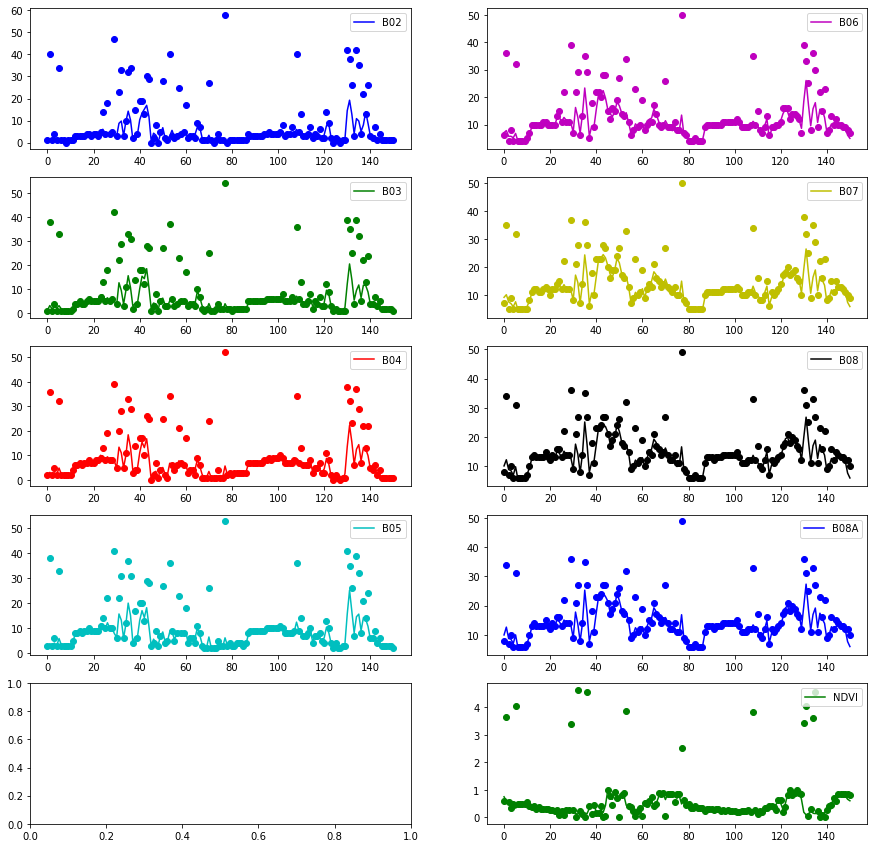

In [13]:
plot(data, pred, pixel_id=2115)

In [14]:
state = {
            'state_dict': coder.state_dict(),
    }
torch.save(state, 'coder.stt')